[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 2
[LightGBM] [Info] Start training from score 20.059894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 32023, number of used features: 2
[LightGBM] [Info] Start training from score 20.057512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

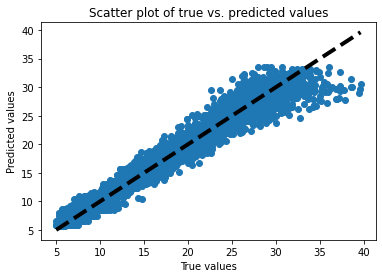

Training set:
R2: 0.9709924451105532
NSE: 0.9709924451105532
RMSE: 0.9314099621681042
MAE: 0.6480875267177961

Testing set:
R2: 0.9635888757849427
NSE: 0.9635888757849427
RMSE: 1.04725257952308
MAE: 0.7124380634510364


In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load and preprocess the dataset
data = pd.read_csv('CanopyTempWeatherSC.csv')

# Load and preprocess the dataset
#data = data.dropna() 
data['CanopyTemp'] = data['CanopyTemp'].astype(float)
data_filted = data[(data['CanopyTemp'] >= 5) & (data['CanopyTemp'] <= 40)]

X = data_filted.iloc[:, [6,7]].values
#X = data_filted.iloc[:, 3:14].values

# Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data_filted.iloc[:, 4].values 
y = y.reshape(-1, 1)
y = np.ravel(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the LightGBM model
model = lgb.LGBMRegressor()

# Define the grid of hyperparameters to search over
#param_grid = {
#    'num_leaves': [4,5,6],
#    'learning_rate': [0.01],
#    'n_estimators': [100],
#    'reg_alpha': [0.01],
#    'reg_lambda': [0.01],
#}

param_grid = {
    'num_leaves': [100],
    'learning_rate': [0.3],
    'n_estimators': [300],
    'reg_alpha': [0.01],
    'reg_lambda': [0.01],
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the model with the best hyperparameters
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the final model
T4SCSM1_GBM = pd.DataFrame({'Measured_T4SCSM1_LightGBM': y_test.flatten(), 'Estimated_T4SCSM1_LightGBM': y_pred.flatten()})

# Save the DataFrame to a file
T4SCSM1_GBM.to_csv('SCSM12_LightGBM.csv', index=False)

# Print the final training and testing loss
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')

# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()  

y_train_pred = best_model.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred= y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred)/mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

metricstrain = [
    {'Metric': 'RMSE', 'Value': train_r2},
    {'Metric': 'R2', 'Value': train_nse},
    {'Metric': 'NSE', 'Value': train_rmse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(metricstrain)
df.to_csv('LightGBMSC_trainmetrics.csv', index=False)


y_test_pred = best_model.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred)/mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

metricstest = [
    {'Metric': 'RMSE', 'Value': test_r2},
    {'Metric': 'R2', 'Value': test_nse},
    {'Metric': 'NSE', 'Value': test_rmse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(metricstest)
df.to_csv('LightGBMSC_testmetrics.csv', index=False)